# Statistical Analysis

## Imports

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pipeline import *


## Load Data

In [35]:
df_teams = pd.read_csv("dataset/cleaned/teams.csv")
df_teams_post = pd.read_csv("dataset/cleaned/teams_post.csv")

df_series_post = pd.read_csv("dataset/cleaned/series_post.csv")
df_coaches = pd.read_csv("dataset/cleaned/coaches.csv")
df_awards_players = pd.read_csv("dataset/cleaned/awards_players.csv")

aux_1 = pd.read_csv("dataset/cleaned/players.csv")
aux_2 = pd.read_csv("dataset/cleaned/players_teams.csv")

df_players = merge_player_info(aux_1, aux_2)


## Functions

In [36]:
def show_corr_matrix(df, threshold=0.8):
    correlation_matrix = df.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()

    num_corr_greater_than_08 = ((correlation_matrix.where(np.tril(
        np.ones(correlation_matrix.shape), k=-1).astype(bool)) > threshold).sum()).sum()
    print("Number of correlation values greater than 0.8:",
          num_corr_greater_than_08)


In [37]:
def show_box_plots(df):
    num_cols = int(len(df.columns)/3)+1
    num_rows = 3
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))
    axs = axs.flatten()

    for i, col in enumerate(df.columns):

        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        num_outliers = len(
            df[(df[col] < lower_bound) | (df[col] > upper_bound)])

        axs[i].boxplot(df[col])
        axs[i].set_ylim(df[col].min() - 0.1 * df[col].max(),
                        df[col].max() + 0.1 * df[col].max())

        axs[i].set_xlabel(f"mean: {df[col].mean():.2f}")

        if num_outliers > 40:
            axs[i].set_title(f"{col} ({num_outliers} outliers)", color='red')
        else:
            axs[i].set_title(f"{col} ({num_outliers} outliers)")

    fig.suptitle("Box Plots for Attributes")
    plt.tight_layout()
    plt.show()


In [38]:
def show_hist_plots(df):
    num_cols = int(len(df.columns)/3)+1
    num_rows = 3
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))
    axs = axs.flatten()

    for i, col in enumerate(df.columns):
        axs[i].hist(df[col], bins=20)
        axs[i].set_xlabel(f"mean: {df[col].mean():.2f}")
        axs[i].set_title(f"{col}")

    fig.suptitle("Histograms for Attributes")
    plt.tight_layout()
    plt.show()

## Data Cleaning Analysis

### Loading Original Data

In [39]:
df_teams_og = pd.read_csv("dataset/original/teams.csv")
df_teams_post_og = pd.read_csv("dataset/original/teams_post.csv")

df_series_post_og = pd.read_csv("dataset/original/series_post.csv")
df_coaches_og = pd.read_csv("dataset/original/coaches.csv")
df_awards_players_og = pd.read_csv("dataset/original/awards_players.csv")

aux_1 = pd.read_csv("dataset/original/players.csv")
aux_2 = pd.read_csv("dataset/original/players_teams.csv")

df_players_og = merge_player_info(aux_1, aux_2)

### Comparing Original Data to Cleaned Data

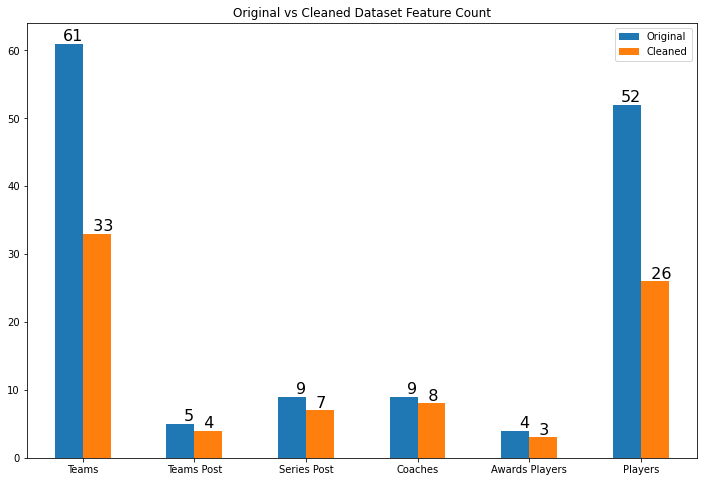

In [43]:
# Comparing the original and cleaned datasets sizes in terms of columns and rows on a graph

df_list = [df_teams_og, df_teams_post_og, df_series_post_og,
           df_coaches_og, df_awards_players_og, df_players_og]

df_list_cleaned = [df_teams, df_teams_post, df_series_post,
                   df_coaches, df_awards_players, df_players]

df_names = ["Teams", "Teams Post", "Series Post",
            "Coaches", "Awards Players", "Players"]


# Get the number of columns in each dataframe
df_sizes = [len(df.columns) for df in df_list]
df_sizes_cleaned = [len(df.columns) for df in df_list_cleaned]

# Create a DataFrame for the original and cleaned dataset sizes
df_sizes = pd.DataFrame(
    {"Original": df_sizes, "Cleaned": df_sizes_cleaned}, index=df_names)

# Create the bar plot
ax = df_sizes.plot.bar(rot=0, figsize=(12, 8))

# Add labels with numbers on top of the rectangles
for i, v in enumerate(df_sizes.index):
    ax.text(i, df_sizes.loc[v, "Original"], str(
        df_sizes.loc[v, "Original"]), ha='right', va='bottom', fontsize=16)
    ax.text(i, df_sizes.loc[v, "Cleaned"], "  "+str(
        df_sizes.loc[v, "Cleaned"]), ha='left', va='bottom', fontsize=16)

# Set the title
plt.title("Original vs Cleaned Dataset Feature Count")
plt.show()


Removed the following columns from the original data:

In [41]:
columns_not_in_cleaned = []

for og_df, cleaned_df in zip(df_list, df_list_cleaned):
    og_columns = set(og_df.columns)
    cleaned_columns = set(cleaned_df.columns)
    columns_diff = og_columns - cleaned_columns
    columns_not_in_cleaned.append(columns_diff)

for i, df_name in enumerate(df_names):
    print(
        f"Columns not in cleaned {df_name} dataframe: {list(columns_not_in_cleaned[i])}")


Columns not in cleaned Teams dataframe: ['opptmTRB', 'name', 'seeded', 'confL', 'o_3pm', 'd_3pa', 'd_reb', 'd_stl', 'opptmDRB', 'd_ftm', 'o_to', 'o_reb', 'awayW', 'firstRound', 'semis', 'divID', 'franchID', 'homeL', 'd_fgm', 'lost', 'arena', 'GP', 'o_fgm', 'confW', 'homeW', 'won', 'tmORB', 'tmDRB', 'o_fta', 'd_fga', 'o_3pa', 'finals', 'd_fta', 'o_ftm', 'o_asts', 'tmTRB', 'd_3pm', 'opptmORB', 'lgID', 'awayL', 'o_fga', 'rank']
Columns not in cleaned Teams Post dataframe: ['lgID']
Columns not in cleaned Series Post dataframe: ['lgIDLoser', 'lgIDWinner']
Columns not in cleaned Coaches dataframe: ['lgID']
Columns not in cleaned Awards Players dataframe: ['lgID']
Columns not in cleaned Players dataframe: ['PostMinutes', 'PostftMade', 'PostTurnovers', 'PostthreeMade', 'blocks', 'PostfgAttempted', 'deathDate', 'PostPF', 'PostthreeAttempted', 'PostPoints', 'PostDQ', 'PF', 'PostdRebounds', 'lastseason', 'fgAttempted', 'threeAttempted', 'firstseason', 'ftAttempted', 'assists', 'steals', 'PostGP',

## Data Preprocessing Analysis

## Analysis - df_teams

### Descriptive Statistics

In [47]:
df_pred = player_rankings(df_players)
df_players_teams = player_in_team_by_year(df_players)
df_players_teams = team_mean(df_players_teams, df_pred)

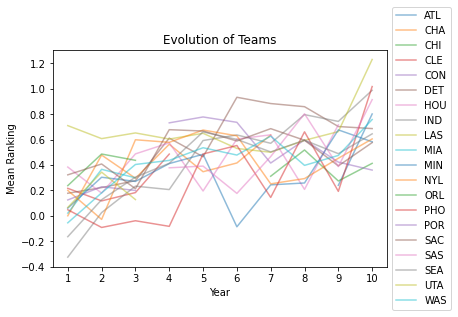

In [60]:
df_teams_evolution = df_players_teams.groupby(['tmID', 'year']).agg({
    'mean': 'mean'
}).reset_index()


df_teams_evolution = df_teams_evolution.pivot(
    index='year', columns='tmID', values='mean')

df_teams_evolution.plot(kind='line', stacked=False, alpha=0.5)

# Set the title and axis labels
plt.title('Evolution of Teams')
plt.xlabel('Year')
plt.ylabel('Mean Ranking')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(df_teams_evolution.index)
plt.show()


# NOTA: as primeiras epocas tem menos pontuação porque tem ...
# jogadores com rankings que n são tão precisos. Uma vez que jogaram menos jogos
# TODO: podemos calcular os rankings progressivamente para um grafico mais preciso
